# Human Activity Recognition
---

## Project Overview

<a href = 'http://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones'>UCI Human Activity Recognition Using Smartphones Data Set</a>

<table align = 'left'>
    <thead>
    </thead>
    <tbody>
        <tr>
            <td>associated tasks</td>
            <td>classification, clustering</td>
        </tr>
        <tr>
            <td>dataset characteristics</td>
            <td>multivariate, time-series</td>
        </tr>
        <tr>
            <td>number of instances</td>
            <td>10299</td>
        </tr>
        <tr>
            <td>number of features</td>
            <td>561</td>
        </tr>
    </tbody>
</table>

### Problem Statement
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years.

Each person performed six activities
- WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING

wearing a smartphone (Samsung Galaxy S II) on the waist.

Using its embedded accelerometer and gyroscope, we captured
- 3-axial linear acceleration and
- 3-axial angular velocity

at a constant rate of 50Hz.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window).

The experiments have been video-recorded to label the data manually.

The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

<a href = 'https://www.youtube.com/watch?v=XOEN9W05_4A'>Example video of experiment</a>

### Data
Feature information:

For each record in the dataset it is provided:
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
- Triaxial Angular velocity from the gyroscope.
- A 561-feature vector with time and frequency domain variables.
- Its activity label.
- An identifier of the subject who carried out the experiment.

- Features are normalized and bounded within \[-1,1\]
- Each feature vector is a row on the text file.
- The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).
- The gyroscope units are rad/seg.

### Evaluation Metric
- Evaluation Metric: F1-Score, Confusion Matrix
- Loss: Categorical Cross-Entropy

## Data Exploration

### General imports and vars

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import defaultdict
import warnings
import math
import time

warnings.filterwarnings ("ignore", category=FutureWarning)

sns.set_style ('whitegrid')

DATA_X_TRAIN = os.path.join ('data', 'UCI HAR Dataset', 'UCI HAR Dataset', 'train', 'X_train.txt')
DATA_Y_TRAIN = os.path.join ('data', 'UCI HAR Dataset', 'UCI HAR Dataset', 'train', 'y_train.txt')
DATA_X_TEST = os.path.join ('data', 'UCI HAR Dataset', 'UCI HAR Dataset', 'test', 'X_test.txt')
DATA_Y_TEST = os.path.join ('data', 'UCI HAR Dataset', 'UCI HAR Dataset', 'test', 'y_test.txt')
DATA_FEATURES = os.path.join ('data', 'UCI HAR Dataset', 'UCI HAR Dataset', 'features.txt')
DATA_LABELS = os.path.join ('data', 'UCI HAR Dataset', 'UCI HAR Dataset', 'activity_labels.txt')

### check file size and contents

In [2]:
# get rows of train and test data
n_rows_train = 0
with open (DATA_X_TRAIN) as file:
    n_rows_train = len (file.readlines())

print ('Exact number of rows in train file:', n_rows_train)

n_rows_test = 0
with open (DATA_X_TEST) as file:
    n_rows_test = len (file.readlines())

print ('Exact number of rows in test file:', n_rows_test)

print ('number of instances in whole dataset:', n_rows_train + n_rows_test)

Exact number of rows in train file: 7352
Exact number of rows in test file: 2947
number of instances in whole dataset: 10299


### load the dataset

In [3]:
# feature information - contains header of raw df
header = pd.read_csv (
    DATA_FEATURES,
    header = None,
    names = ['feature_no', 'feature_name'],
    sep = '\s+',
    dtype = 'str'
)

# read train data incl. header as column names
data_xtrain_raw = pd.read_csv (
    DATA_X_TRAIN,
    header = None,
    names = (header['feature_no'] + '_' + header['feature_name']).values,
    sep = '\s+'
)
display (data_xtrain_raw.sample (2))

,1_tBodyAcc-mean()-X,2_tBodyAcc-mean()-Y,3_tBodyAcc-mean()-Z,4_tBodyAcc-std()-X,5_tBodyAcc-std()-Y,6_tBodyAcc-std()-Z,7_tBodyAcc-mad()-X,8_tBodyAcc-mad()-Y,9_tBodyAcc-mad()-Z,10_tBodyAcc-max()-X,...,552_fBodyBodyGyroJerkMag-meanFreq(),553_fBodyBodyGyroJerkMag-skewness(),554_fBodyBodyGyroJerkMag-kurtosis(),"555_angle(tBodyAccMean,gravity)","556_angle(tBodyAccJerkMean),gravityMean)","557_angle(tBodyGyroMean,gravityMean)","558_angle(tBodyGyroJerkMean,gravityMean)","559_angle(X,gravityMean)","560_angle(Y,gravityMean)","561_angle(Z,gravityMean)"
570,0.278321,-0.025827,-0.094847,-0.998256,-0.964521,-0.968696,-0.998401,-0.962323,-0.965757,-0.943001,...,-0.118342,0.092849,-0.283188,0.035385,0.083077,-0.25582,-0.009866,-0.918488,0.083827,0.077023
1457,0.363755,0.001903,-0.087166,-0.340510,-0.392420,-0.218647,-0.374000,-0.428081,-0.184888,-0.140288,...,0.160709,-0.356138,-0.726124,-0.326015,-0.640971,0.70298,0.925899,-0.477281,0.199854,0.376377


There are 561 features per instance. The features are metric ratio scaled in continuous space.

### statistics about dataset

In [4]:
display (data_xtrain_raw.describe ())

,1_tBodyAcc-mean()-X,2_tBodyAcc-mean()-Y,3_tBodyAcc-mean()-Z,4_tBodyAcc-std()-X,5_tBodyAcc-std()-Y,6_tBodyAcc-std()-Z,7_tBodyAcc-mad()-X,8_tBodyAcc-mad()-Y,9_tBodyAcc-mad()-Z,10_tBodyAcc-max()-X,...,552_fBodyBodyGyroJerkMag-meanFreq(),553_fBodyBodyGyroJerkMag-skewness(),554_fBodyBodyGyroJerkMag-kurtosis(),"555_angle(tBodyAccMean,gravity)","556_angle(tBodyAccJerkMean),gravityMean)","557_angle(tBodyGyroMean,gravityMean)","558_angle(tBodyGyroJerkMean,gravityMean)","559_angle(X,gravityMean)","560_angle(Y,gravityMean)","561_angle(Z,gravityMean)"
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [5]:
# min
unique_values, counts = np.unique ((data_xtrain_raw.describe ().loc['min'] <= -1.).values, return_counts = True)
print ('min = -1.', unique_values, counts)

# max
unique_values, counts = np.unique ((data_xtrain_raw.describe ().loc['max'] >= 1.).values, return_counts = True)
print ('max = +1.', unique_values, counts)

min = -1. [False  True] [ 95 466]
max = +1. [False  True] [109 452]


Most features ar normalized within [-1, 1]. (be aware: they are normalized, and not standardized to $\mu = 0, \sigma = 1$)

All features are bound within range [-1, 1].

By that, it is guaranteed that the values are within a range, but skewness in features is present.

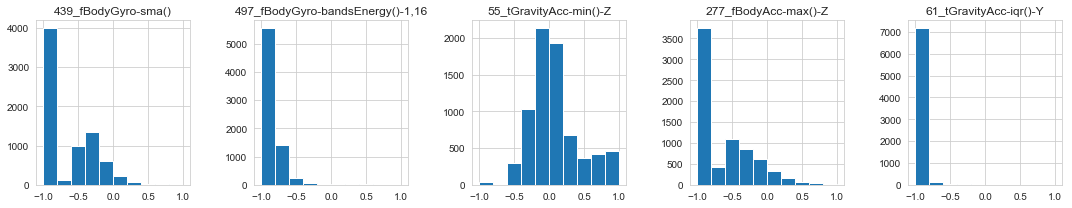

In [6]:
# histograms of random chosen features to show normalization and skewness
rnd_col_no_idx = np.random.randint (0, 561, 5)
rnd_col_names = data_xtrain_raw.columns[rnd_col_no_idx].values

fig, axs = plt.subplots (1, len (rnd_col_no_idx))

for i in range (len (axs)):
    axs[i].hist (data_xtrain_raw[rnd_col_names[i]])
    axs[i].set_title (rnd_col_names[i])

fig.set_size_inches (15, 3)
plt.tight_layout ()
plt.show ()

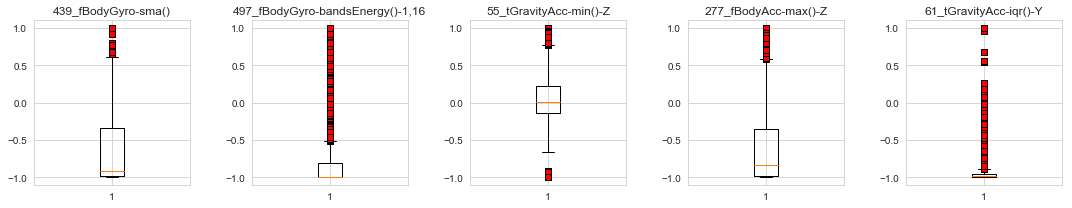

In [7]:
fig, axs = plt.subplots (1, len (rnd_col_no_idx))

for i in range (len (axs)):
    axs[i].boxplot (
        x = data_xtrain_raw[rnd_col_names[i]],
        flierprops = dict (
            markerfacecolor = 'r',
            marker = 's'
        )
    )
    axs[i].set_title (rnd_col_names[i])

fig.set_size_inches (15, 3)
plt.tight_layout ()
plt.show ()

Statistically seen there may be many outliers per feature.

Outliers harm the training of a learning algorithm. Nevertheless, removing outliers from the dataset lead to a decrease of training samples.

__Question:__ What can we do to identify true outliers within 561 features? Correlation? PCA? Feature importance check? What if outliers are target specific characteristics?

The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2).

The gyroscope units are rad/seg.

Since we have different units, it is advised to standardize the data.

### targets of dataset

In [8]:
# label information - contains header of raw df
header_labels = pd.read_csv (
    DATA_LABELS,
    header = None,
    names = ['label_no', 'label_name'],
    sep = '\s+',
    dtype = 'str'
)

# read train label data incl. header as column names
data_ytrain_raw = pd.read_csv (
    DATA_Y_TRAIN,
    header = None,
    names = ['label_no'],
    sep = '\s+'
)

display (header_labels)
display (data_ytrain_raw.sample (2))

,label_no,label_name
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


,label_no
3256,5
2397,5


Labels are in nominal scaled range [1, 6].

### training samples per target

In [9]:
# count instances per label

overall_count = 0
print ('label no    count')
for label_no in range (1, 7):
    label_no_idx = data_ytrain_raw[data_ytrain_raw['label_no'] == label_no].index.values
    print ('{:8}    {}'.format (label_no, len (label_no_idx)))
    overall_count += len (label_no_idx)
    #label_no_fts = data_xtrain_raw.iloc[label_no_idx]
    #label_no_fts.describe ()
print (overall_count)

label no    count
       1    1226
       2    1073
       3    986
       4    1286
       5    1374
       6    1407
7352


Is okay. There are enough instances per label.

## Benchmark
some other algorithm / software / result to compare this algorithm against (by using the defined metric)

random guess

---

## Metric

### Loss Function

The learning problem is a multi-class classification problem.

very good explanation to Cross Entropy: <a href = 'https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/'>A Friendly Introduction to Cross-Entropy Loss</a>

explanation to Categorical Cross Entropy: <a href = 'https://gombru.github.io/2018/05/23/cross_entropy_loss/'>Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names</a>

_Entropy_:

If you know the distribution of y, then the expected number of bits under an optimal encoding is.

$H(y) = \sum_i {y_i \cdot log(1 / y_i)} = - \sum_i {y_i \cdot log(y_i)}$

_Cross Entropy_:

Number of bits you need to encode y, if you encode according to the wrong distribution $\hat y$.

$H(y, \hat y) = \sum_i {y_i \cdot log(1 / \hat y_i)} = - \sum_i {y_i \cdot log(\hat y_i)}$

$y$ = true distribution / ground-truth probabilities

$\hat y$ = 'artifical' distribution / predicted probabilities

_Cross Entropy Loss_:

Also known as Logistic Loss and Multinomial Logistic Loss.

Don't use Softmax activation with Cross Entropy Loss -- use Sigmoid activation instead.

_Categorical Cross Entropy Loss_:

Also known as Softmax Loss. Used for multi-class classification.

CCE is Softmax activation followed by CE:

$\sigma(\hat y_i) = \frac {e^{\hat y_i}} {\sum_j {e^{\hat y_j}}}$

$CCE = - \sum_i {y_i \cdot log(\sigma(\hat y_i))}$

### Evaluation Metric

F-beta score

$F_\beta = (1+\beta)^2 \cdot \frac {prec \cdot rec} {\beta^2 \cdot prec + rec}$

beta = 0.5, since a precise learning algorithm is the aim, i.e. Type I Errors (False Positives) shall be ommitted.

$F_\beta$ is in range [0, 1] [worst, best]


## Data Preprocessing

### Feature Selection
Get rid of unimportant features (for the learning algorithm),

Nothing to do here.

### Removing Outliers
by finding all instances, with outliers outside of $3 \cdot IQR$ of feature and # of features with outliers > 50%.

In [10]:
# calculate 3 * IQR min and max for each feature
data_xtrain_stats = data_xtrain_raw.describe ()
data_xtrain_iqr = (data_xtrain_stats.loc['75%'] - data_xtrain_stats.loc['25%']).values # per feature

data_xtrain_iqr_3min = data_xtrain_stats.loc['25%'].values - 3 * data_xtrain_iqr # per feature
data_xtrain_iqr_3max = data_xtrain_stats.loc['75%'].values + 3 * data_xtrain_iqr # per feature

#print (data_xtrain_raw.values.shape, data_xtrain_iqr_3min.shape) # trailing axes must have same dimension, i.e. mxn, nx1

# get instances which have outliers
outliers_min = np.where (data_xtrain_raw.values < data_xtrain_iqr_3min)
outliers_max = np.where (data_xtrain_raw.values > data_xtrain_iqr_3max)

# count # of features per instance exceeds 560 / 2 = 280
# run thru every instance
for i in outliers_min[0]:
    # get # of features with outliers
    pass
#set (list (outliers_min[1]))

# have currently no idea how to further proceed

### Downscaling of Feature values
Normalization on standardized features didn't work out -> another approach: Scale each feature down by a certain factor (one factor for all features!)

Factor = 100

__[2018-12-14:dh]__ Scaling the feature values beforehand has no effect on later standardization!

In [11]:
# min and max
print (data_xtrain_raw.values.min (), data_xtrain_raw.values.max ())

# zero values
zero_idx = np.where (data_xtrain_raw.values == 0)
print (len (zero_idx[0]))
# lowest values close to zero
#print (np.where ((-1e-100 < data_xtrain_raw.values) & (data_xtrain_raw.values < 1e-100)))

-1.0 1.0
555


Standard deviation is affected by downscaling factor -> First downscale and then standardize features.

### Standardization
also known as Z-score Normalization

Standardizing the features so that they are centered at 0 with a standard deviation of 1.

$z = \frac{x-u}{s}$

with

$u = \frac1N \sum_{i=1}^N {x_i}$

$s = \sqrt {\frac1N \sum_{i=1}^N ({x_i - u})^2}$

Centering and scaling happen independently on each feature.

Furthermore and important: the units of the features vanish with standardization -> comparison between features is possible

In [12]:
# standardize data to mu = 0, sigma = 1
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler ()

n_samples = data_xtrain_raw.index.values
n_features = data_xtrain_raw.values
#data = np.vstack ((n_samples, n_features)).T
data = n_features

std_scaler.fit (data) # expects array with [n_samples, n_features]
Z = std_scaler.transform (data)

std_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

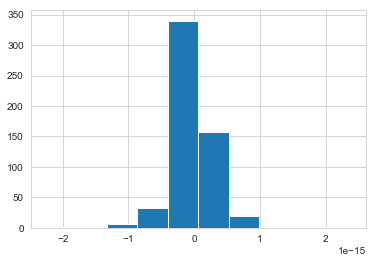

In [13]:
plt.hist (Z.mean (axis = 0));

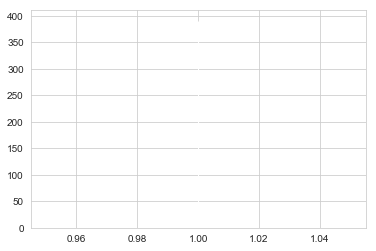

In [14]:
plt.hist (Z.std (axis = 0));

In [15]:
Z.min (), Z.max ()

(-24.071520643074255, 34.19405648585853)

### Shuffle and Split into Train and Val Dataset

In [16]:
# shuffle data randomly
from sklearn.model_selection import train_test_split

RND_STATE = 42

X = Z
y = data_ytrain_raw['label_no'].values

X_train, X_val, y_train, y_val = train_test_split (
    X, y,
    test_size = 0.2,
    shuffle = True,
    random_state = RND_STATE
)

# one-hot encode target labels
y_train = pd.get_dummies (y_train).values
y_val = pd.get_dummies (y_val).values


X_train.shape, y_train.shape, X_val.shape, y_val.shape

((5881, 561), (5881, 6), (1471, 561), (1471, 6))

## Implementation
MLP is used built up on Keras.

Architecture of the MLP is random. Dropout is once used.

In [17]:
from keras import layers, models
from keras import backend as K

# clear everything known of past instances ("useful to avoid clutter from old models / layers")
K.clear_session ()


# input layer
inputs = layers.Input (
    shape = X_train.shape[1:],
    name = 'input'
)

net = layers.Dense (
    units = 512,
    activation = 'relu',
    name = 'fc_1'
) (inputs)

net = layers.Dense (
    units = 256,
    activation = 'relu',
    name = 'fc_2'
) (net)

net = layers.Dropout (
    rate = 0.5,
    name = 'dro_23'
) (net)

net = layers.Dense (
    units = 128,
    activation = 'relu',
    name = 'fc_3'
) (net)


# output layer
outputs = layers.Dense (
    units = y_train.shape[1],
    activation = 'softmax',
    name='output'
) (net)


model = models.Model (
    inputs = inputs,
    outputs = outputs
)
model.summary ()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 561)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               287744    
_________________________________________________________________
fc_2 (Dense)                 (None, 256)               131328    
_________________________________________________________________
dro_23 (Dropout)             (None, 256)               0         
_________________________________________________________________
fc_3 (Dense)                 (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 6)                 774       
Total params: 452,742
Trainable params: 452,742
Non-trainable params: 0
_________________________________________________________________


In [18]:
# from: Arseny Kravchenko http://arseny.info/2017/f-beta-score-for-keras.html

PARAM_BETA = 0.5
def fbeta (y_true, y_pred):

    # just in case of hipster activation at the final layer
    y_pred = K.clip (y_pred, 0, 1)

    tp = K.sum (K.round (y_true * y_pred)) + K.epsilon ()
    fp = K.sum (K.round (K.clip (y_pred - y_true, 0, 1)))
    fn = K.sum (K.round (K.clip (y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = PARAM_BETA ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall)

In [19]:
from keras import optimizers, losses

PARAM_LR = 0.0001
PARAM_MOM = 0.9
PARAM_LRDEC = 0
opt = optimizers.SGD (lr=PARAM_LR, momentum=PARAM_MOM, decay=PARAM_LRDEC)

loss = losses.categorical_crossentropy

model.compile (optimizer=opt, loss=loss, metrics=[fbeta])

In [20]:
print ('training set: features {}, targets {}'.format (X_train.shape, y_train.shape))
print ('validation set: features {}, targets {}'.format (X_val.shape, y_val.shape))
scalars_train, scalars_val = [], []

# batch run
PARAM_N_BATCH = 20
max_batches = X_train.shape[0] // PARAM_N_BATCH
last_batch = X_train.shape[0] % PARAM_N_BATCH

# training
PARAM_MAX_EPOCHS = 25

epoch = 1
while (epoch <= PARAM_MAX_EPOCHS):
    
    start_time = time.time ()
    
    print ('epoch {}:'.format (epoch))
    
    for i in range (max_batches):
        # training
        print ('\r', (i+1)*PARAM_N_BATCH, '/', X_train.shape[0], end=', ')
        ret = model.train_on_batch (
            X_train[i*PARAM_N_BATCH:(i+1)*PARAM_N_BATCH], y_train[i*PARAM_N_BATCH:(i+1)*PARAM_N_BATCH])
        
        # validation
        val = model.test_on_batch (X_val, y_val)
    
    if (last_batch > 0):
        # training
        print ('\r', max_batches * PARAM_N_BATCH + last_batch, '/', X_train.shape[0], end=', ')
        ret = model.train_on_batch (X_train[-last_batch:], y_train[-last_batch:])
        
        # validation
        val = model.test_on_batch (X_val, y_val)
    
    # print results
    print (model.metrics_names[0], ret[0], end=' ')
    print (model.metrics_names[1], ret[1], end=', ')
    print ('val', model.metrics_names[0], val[0],'val', model.metrics_names[1], val[1])
    
    scalars_train.append (ret)
    scalars_val.append (val)
    
    epoch += 1
    
    end_time = time.time () - start_time
    print ('[i] time taken for last epoch: {:.2f} s'.format (end_time))
    print ('[i] estimation for remaining epochs: {:.2f} s'.format (end_time * (PARAM_MAX_EPOCHS-epoch+1)))

training set: features (5881, 561), targets (5881, 6)
validation set: features (1471, 561), targets (1471, 6)
epoch 1:
 5881 / 5881, loss 1.3176504 fbeta 4.9999977e-07, val loss 0.93344814 val fbeta 0.5927249
[i] time taken for last epoch: 6.77 s
[i] estimation for remaining epochs: 162.39 s
epoch 2:
 5881 / 5881, loss 0.20314375 fbeta 1.0, val loss 0.67598873 val fbeta 0.8108905
[i] time taken for last epoch: 6.30 s
[i] estimation for remaining epochs: 144.84 s
epoch 3:
 5881 / 5881, loss 0.33538765 fbeta 1.0, val loss 0.5256088 val fbeta 0.86383605
[i] time taken for last epoch: 6.31 s
[i] estimation for remaining epochs: 138.89 s
epoch 4:
 5881 / 5881, loss 0.14380692 fbeta 1.0, val loss 0.43125018 val fbeta 0.88972425
[i] time taken for last epoch: 6.30 s
[i] estimation for remaining epochs: 132.24 s
epoch 5:
 5881 / 5881, loss 0.1691131 fbeta 1.0, val loss 0.3633189 val fbeta 0.902277
[i] time taken for last epoch: 6.28 s
[i] estimation for remaining epochs: 125.63 s
epoch 6:
 588

---

## Evaluation and Validation
results and justification

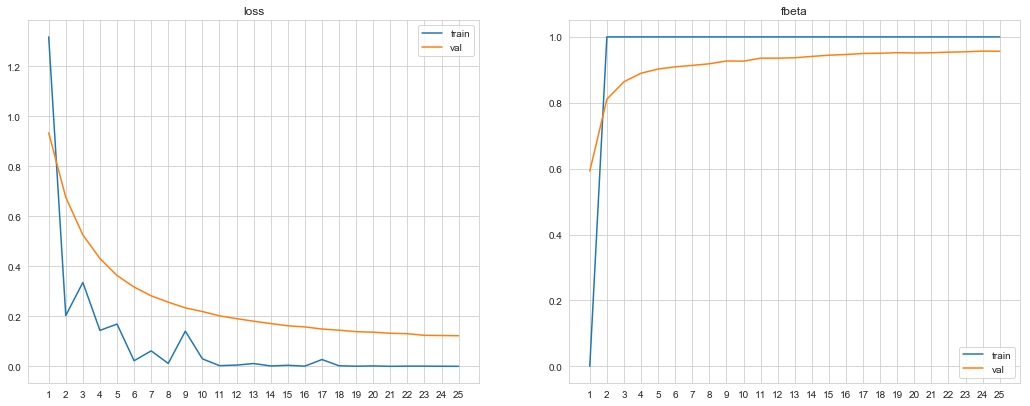

In [21]:
df_train = pd.DataFrame (scalars_train, columns=model.metrics_names)
df_val = pd.DataFrame (scalars_val, columns=model.metrics_names)

fig, axs = plt.subplots (1, 2)

for i in range (2):
    axs[i].set_title (model.metrics_names[i])
    axs[i].plot (df_train[model.metrics_names[i]])
    axs[i].plot (df_val[model.metrics_names[i]])
    axs[i].legend (['train', 'val'])
    axs[i].set_xticklabels (np.arange (1, len (scalars_train) + 1, 1))
    axs[i].set_xticks (np.arange (0, len (scalars_train), 1))

fig.set_size_inches (640*2/fig.dpi, 480/fig.dpi)

Very good loss curve. The spikes in the train loss yield from the dropout dro_23.

Validation curve for both loss and fbeta is nice too, smooth descend / ascend.

### Evaluation on test dataset

In [22]:
# read test data incl. header as column names
data_xtest_raw = pd.read_csv (
    DATA_X_TEST,
    header = None,
    names = (header['feature_no'] + '_' + header['feature_name']).values,
    sep = '\s+'
)

# read test label data incl. header as column names
data_ytest_raw = pd.read_csv (
    DATA_Y_TEST,
    header = None,
    names = ['label_no'],
    sep = '\s+'
)

In [23]:
X_test = std_scaler.transform (data_xtest_raw.values)
y_test = data_ytest_raw.values.reshape (-1)

# one-hot encode target labels
y_test = pd.get_dummies (y_test).values


X_test.shape, y_test.shape

((2947, 561), (2947, 6))

In [24]:
model.evaluate (X_test, y_test)

2947/2947 [==============================] - 0s 42us/step


[0.17691901695548296, 0.9323013436604161]

## Misc

### save learning algorithm

In [25]:
# serialization of model architecture
import os
import time
import pandas as pd

t = time.strftime ("%Y%m%d-%H%M%S", time.gmtime ())

# save model architecture
save_name = os.path.join ('model', t + '_model.arch' + '.yaml')
print ('>>> saving model architecture...', end=' ', flush=True)
yaml_string = model.to_yaml ()
with open (save_name, 'w') as yaml_file:
    yaml_file.write (yaml_string)
print ('done')

# save model weights
save_name = os.path.join ('model', t + '_model.weights' + '.h5')
print ('>>> saving model weights...', end=' ', flush=True)
model.save_weights (save_name)
print ('done')

# save learning history
#save_name = os.path.join ('model', t + '_model.hist' + '.csv')
print ('>>> saving model history...', end=' ', flush=True)
#hist_df = pd.DataFrame.from_dict (history.history)
#hist_df.to_csv (save_name)
save_name = os.path.join ('model', t + '_model.hist.train' + '.csv')
df_train.to_csv (save_name)
save_name = os.path.join ('model', t + '_model.hist.val' + '.csv')
df_val.to_csv (save_name)
print ('done')

>>> saving model architecture... done
>>> saving model weights... done
>>> saving model history... done


### load learning algorithm

In [ ]:
# load model architecture
#load_name = os.path.join ('model', '20180908-094455_model.arch.yaml')
#print ('>>> loading and compiling model...', end=' ', flush=True)
#with open (load_name, 'r') as yaml_file:
#    yaml_string = yaml_file.read ()
#model = models.model_from_yaml (yaml_string)
#model.compile (optimizer=opt, loss=loss, metrics=[fbeta])
#print ('done')

# load best weights
#print ('>>> loading best weights into model...', end=' ', flush=True)
#model.load_weights (os.path.join ('model','20180908-094455_model.weights.b.h5'))
#print ('done')

#model.summary ()

---

## Depcrecated / FYI

### Normalization
Values became bigger due to standardization. The taken learning algorithm works better with low values, since then the weights are kept low.

Normalization per feature to range [-1, 1].

$x_{std} = \frac {x - x_{min}}{x_{max} - x_{min}}$

$x_{scaled} = x_{std} \cdot ({max - min}) + {min}$

In [ ]:
# values are bigger than before -> normalize to [-1, 1] again
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler (
    feature_range = (-1, 1)
)

mm_scaler.fit (Z)
Z_norm = mm_scaler.transform (Z)

mm_scaler

In [ ]:
# example for prove
print (Z_norm[:, 0].min (), Z_norm[:, 0].max ())
print (Z_norm[:, 0].mean (), Z_norm[:, 0].std ())

In [ ]:
plt.hist (Z_norm[:, 0])

### Outliers

In [ ]:
fig, axs = plt.subplots (1, 1)

axs.boxplot (
    x = data_xtrain_raw['129_tBodyGyro-mad()-Z'],
    flierprops = dict (
        markerfacecolor = 'r',
        marker = 's'
    )
)
axs.set_title ('129_tBodyGyro-mad()-Z')

fig.set_size_inches (4, 4)
plt.tight_layout ()
plt.show ()

data_xtrain_raw['129_tBodyGyro-mad()-Z'].describe ()

25th percentile (1st quartile $Q_1$) = -0.987637 -- 25% of values are lower or equal to this value

50th percentile (2nd quartile $Q_2$) = -0.896950 -- 50% of values are lower or equal to this value, also known as median

75th percentile (3rd quartile $Q_3$) = -0.359388 -- 75% of values are lower or equal to this value

(Interquartile Range) IQR = $Q_3 - Q1$ = -0.359388 - -0.987637 = 0.628249

Whiskers range go up to $1.5 \cdot IQR$ = $1.5 \cdot 0.628249$ = 0.9423735

Whisker_min = $Q_1 - 1.5 \cdot IQR$ = -0.987637 - 0.9423735 = -1.9300105 -- value is bigger than min () > set Whisker_min = min () = -0.999915, no outliers

Whisker_max = $Q_3 + 1.5 \cdot IQR$ = -0.359388 + 0.9423735 = 0.5829855 -- value is smaller than max () > all values above Whisker_max are considered as outliers

### Subset of data for test with algorithm

In [ ]:
# take out 200 samples (~ 20% of dataset) per target label for test purposes first
# remark: take Z, not Z_norm, for this task since normalization on standardized features failed
import random
from collections import defaultdict

X = Z
y = data_ytrain_raw['label_no'].values

X_list = []
y_list = []
for label in range (y.min (), y.max () + 1):
    label_idx = list (np.where (y == label)[0])
    samples_200 = random.sample (label_idx, 200)
    X_list.append (X[samples_200])
    y_list.append ([label] * 200)

X_small = np.array (X_list).reshape (-1, Z.shape[1])
y_small = np.array (y_list).reshape (-1)

X_small.shape, y_small.shape

### Loss vs Learning Rate

In [ ]:
# learning rate changer
LR_MAX = 1.5
scalars_lr = np.exp (
    np.arange (
        math.log (PARAM_LR),
        math.log (LR_MAX),
        (math.log (LR_MAX) - math.log (PARAM_LR)) / PARAM_MAX_EPOCHS
    )
)


# per epoch
# learning rate update
current_lr = K.get_value (model.optimizer.lr)
print ('current lr:', current_lr)
new_lr = scalars_lr[epoch-1]
K.set_value (model.optimizer.lr, new_lr)
print ('new lr:', new_lr)

In [ ]:
# loss vs learning rate -- only important if problems during training process
fig, axs = plt.subplots (1, 1)

df_train = pd.DataFrame (scalars_train, columns=model.metrics_names)
axs.plot (scalars_lr, df_train['loss'])
axs.set (ylabel='loss', xlabel='learning rate', title='loss vs learning rate')
axs.set_xscale ('log')
axs.grid ()

fig.set_size_inches (640/fig.dpi, 480/fig.dpi)